## Import Dependencies and Data

In [33]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [34]:
df = pd.read_csv('fetal_health.csv')

## Summarize Data

In [35]:
print('Dataframe head:\n', df.head(), '\n')
print('Dataframe tail:\n', df.tail(), '\n')
print('Data column summary statistics:\n', df.describe())

Dataframe head:
    baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                

Data Cleaning and Preprocessing
Handle Missing Values: Check for missing or zero values (which seem to be present in 'SkinThickness', 'Insulin', etc.) that may need to be imputed or handled appropriately.
Data Transformation: Normalize or standardize the continuous features such as Glucose, BloodPressure, BMI, etc., as they seem to be on different scales.
Categorical Encoding: If there are any categorical variables not included in the sample provided, they should be encoded properly using techniques like one-hot encoding.

In [36]:
#drop hist features since they seem useless
columns_to_drop = [column for column in df.columns if 'histogram' in column.lower()]
cleaned_df = df.drop(columns=columns_to_drop)

# Display the first few rows of the dataframe to verify the columns have been dropped
cleaned_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,1.0


Exploratory Data Analysis (EDA)
Statistical Summary: Generate descriptive statistics to understand the distribution of the data.
Correlation Analysis: Check the correlation between features to identify multicollinearity.
Visualization: Create visual plots (like histograms, box plots, scatter plots) to see the distribution of features and the relationship between features and the outcome.

In [37]:
# 1. Statistical Summary
statistical_summary = cleaned_df.describe()

# 2. Correlation Analysis
correlation_matrix = cleaned_df.corr()

(statistical_summary, correlation_matrix)

(       baseline value  accelerations  fetal_movement  uterine_contractions  \
 count     2126.000000    2126.000000     2126.000000           2126.000000   
 mean       133.303857       0.003178        0.009481              0.004366   
 std          9.840844       0.003866        0.046666              0.002946   
 min        106.000000       0.000000        0.000000              0.000000   
 25%        126.000000       0.000000        0.000000              0.002000   
 50%        133.000000       0.002000        0.000000              0.004000   
 75%        140.000000       0.006000        0.003000              0.007000   
 max        160.000000       0.019000        0.481000              0.015000   
 
        light_decelerations  severe_decelerations  prolongued_decelerations  \
 count          2126.000000           2126.000000               2126.000000   
 mean              0.001889              0.000003                  0.000159   
 std               0.002960              0.000057 

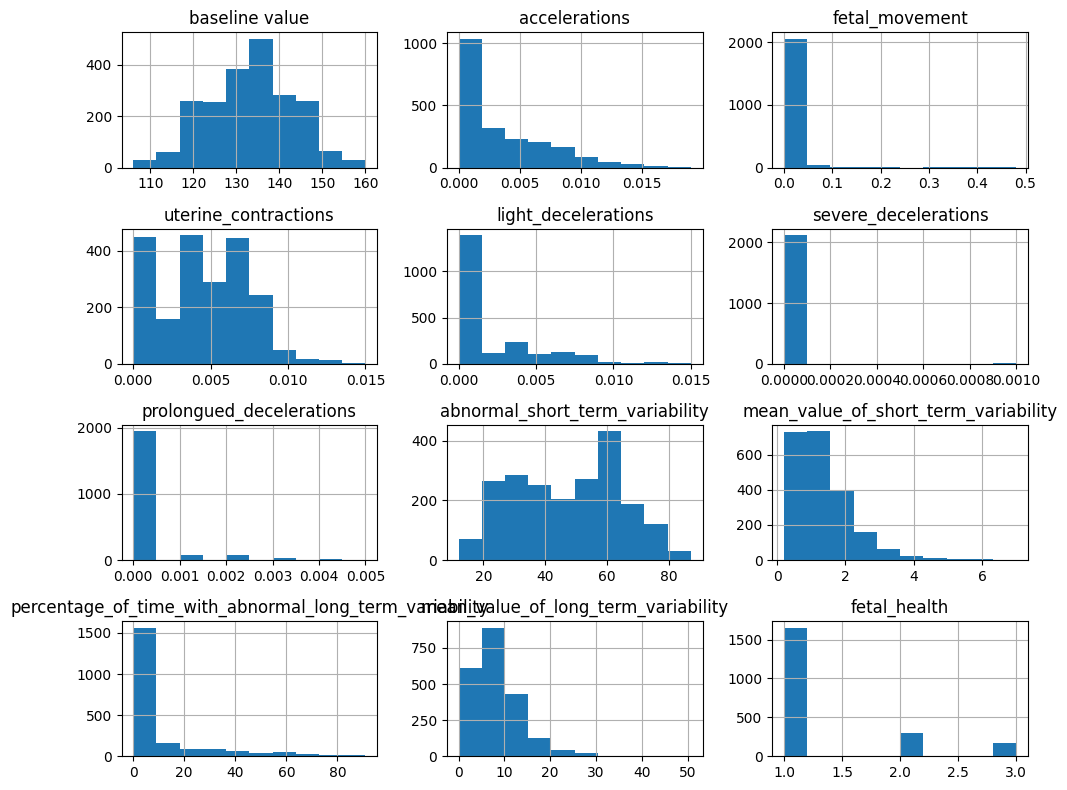

In [38]:
# Histograms for all features
cleaned_df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

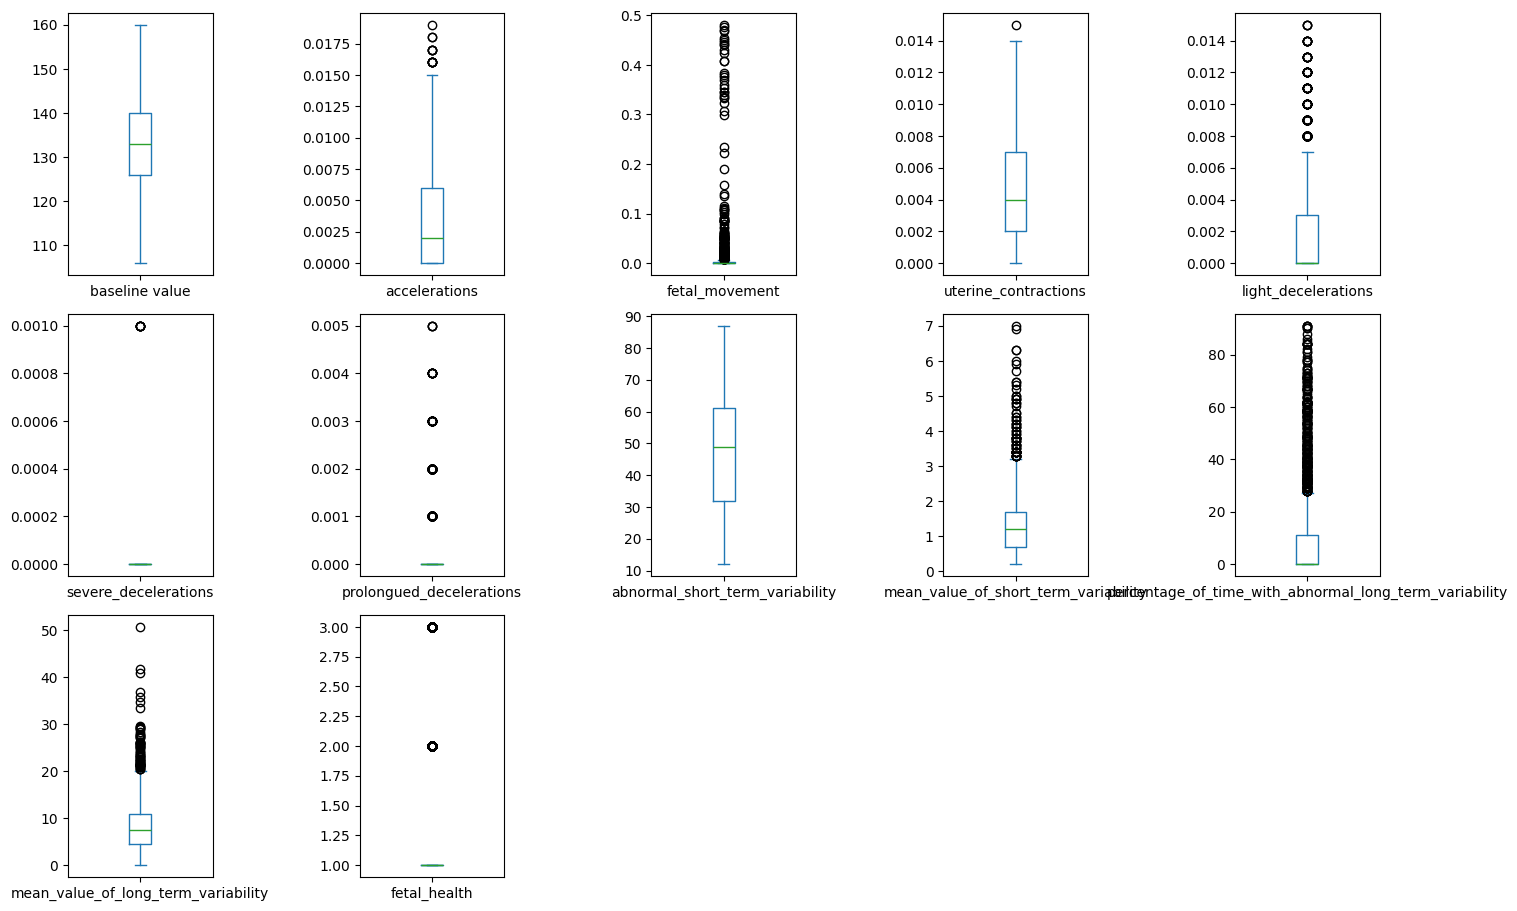

In [39]:
# Box plots for all features
cleaned_df.plot(kind='box', subplots=True, layout=(5,5), figsize=(15, 15))
plt.tight_layout()
plt.show()

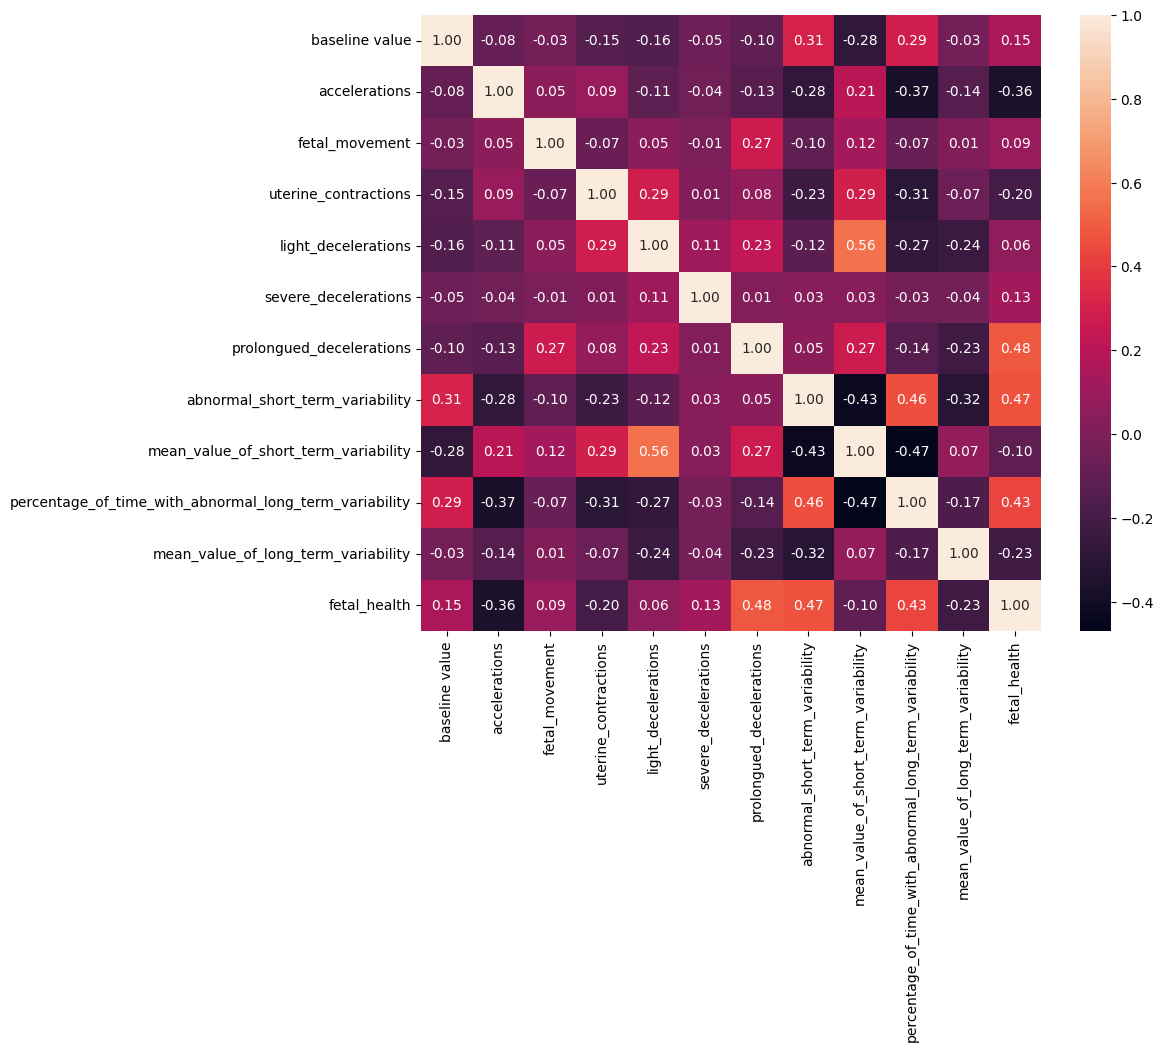

In [40]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cleaned_df.corr(), annot=True, fmt=".2f")
plt.show()

This is a multiclass classification problem because the outcome has three possible labels; the 'fetal_health' oucome can be tagged as 1 (Normal), 2 (Suspect) or 3 (Pathological). 

The natural approach to analyzing this data are decision trees because they can inherently handle multiple classes and are quite interpretable, which is especially important in medical contexts where understanding the decision-making process is crucial. We plan to use Random Forest for this task as it builds upon the concept of decision trees. Random Forest, being an ensemble of decision trees, typically improves upon the performance of a single decision tree by reducing overfitting and variance. Each tree in the forest votes, and the most popular class is chosen as the final outcome, which can yield more reliable predictions.

Model Selection: Random Forest

Decision trees are useful for multiclass classification problems. By utilizing random forest, there will be an ensemble of decision trees that improves predictive performance because it handles overfitting better than individual decision trees.

In [41]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from numpy import unique

# Assume 'cleaned_df' is your DataFrame and it's already loaded and preprocessed.
X = cleaned_df.drop('fetal_health', axis=1)  # Features
y = cleaned_df['fetal_health']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_classifier.predict(X_test)
y_pred_proba_rf = rf_classifier.predict_proba(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Generate a classification report
class_report = classification_report(y_test, y_pred_rf, target_names=['Class 1', 'Class 2', 'Class 3'])

print(accuracy_rf)
print(class_report)

0.9294670846394985
              precision    recall  f1-score   support

     Class 1       0.94      0.98      0.96       497
     Class 2       0.84      0.66      0.74        88
     Class 3       0.94      0.89      0.91        53

    accuracy                           0.93       638
   macro avg       0.91      0.84      0.87       638
weighted avg       0.93      0.93      0.93       638



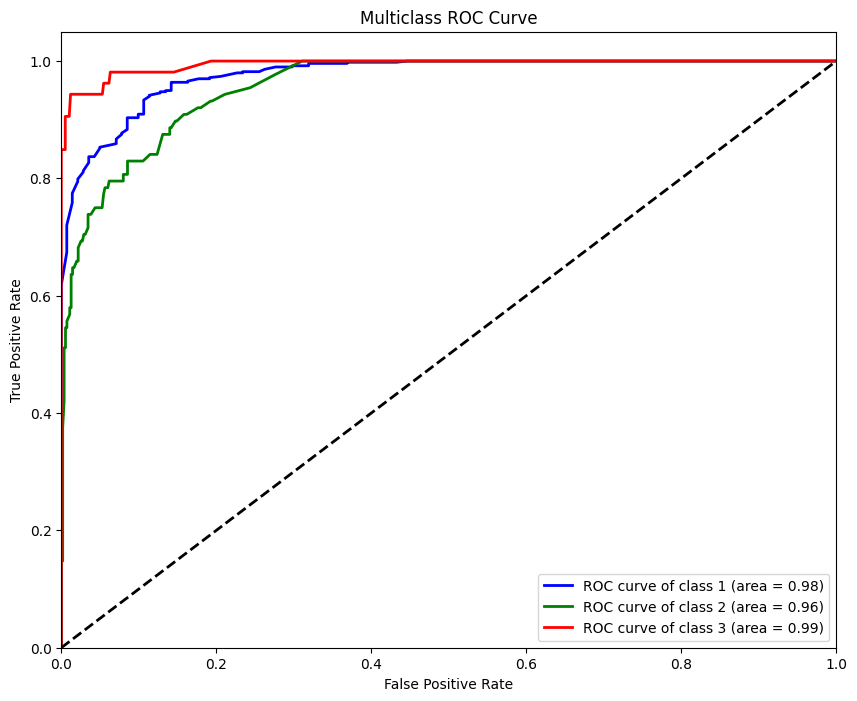

In [42]:
#ROC CURVE
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):  # n_classes is typically 3 for your case
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

Gradient Boosting Machines (GBM) 
GBM, on the other hand, sequentially builds trees where each tree tries to correct the mistakes of the previous one. This can lead to highly accurate models, although they might be less interpretable than single trees.

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting Classifier
gbm_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the classifier
gbm_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_gbm = gbm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_gbm)

# Generate a classification report
classification_report = classification_report(y_test, y_pred_gbm)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report)

Accuracy: 0.9278996865203761
Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      0.97      0.96       497
         2.0       0.86      0.67      0.75        88
         3.0       0.88      0.92      0.90        53

    accuracy                           0.93       638
   macro avg       0.89      0.86      0.87       638
weighted avg       0.93      0.93      0.92       638



Model Training and Evaluation
Training: Train the model(s) on the training dataset.
Evaluation Metrics: Evaluate models using metrics such as accuracy, precision, recall, F1-score, ROC-AUC curve.

Validation
Validation Set: Evaluate the final model on a separate validation set that was not used during the model training phase to check for overfitting.
Learning Curves: Plot learning curves to diagnose if the model is learning well or if it's overfitting or underfitting.

Prediction and Interpretation
Make Predictions: Use the final model to make predictions on new data.
Interpret Results: Use tools like SHAP or LIME for model interpretation to understand how different features affect the outcome.

What features contributed most to the prediction?

Random Forest Feature Importances:
                Feature  Importance
0        baseline value    0.075038
1         accelerations    0.061814
2        fetal_movement    0.037275
3  uterine_contractions    0.067735
4   light_decelerations    0.023876


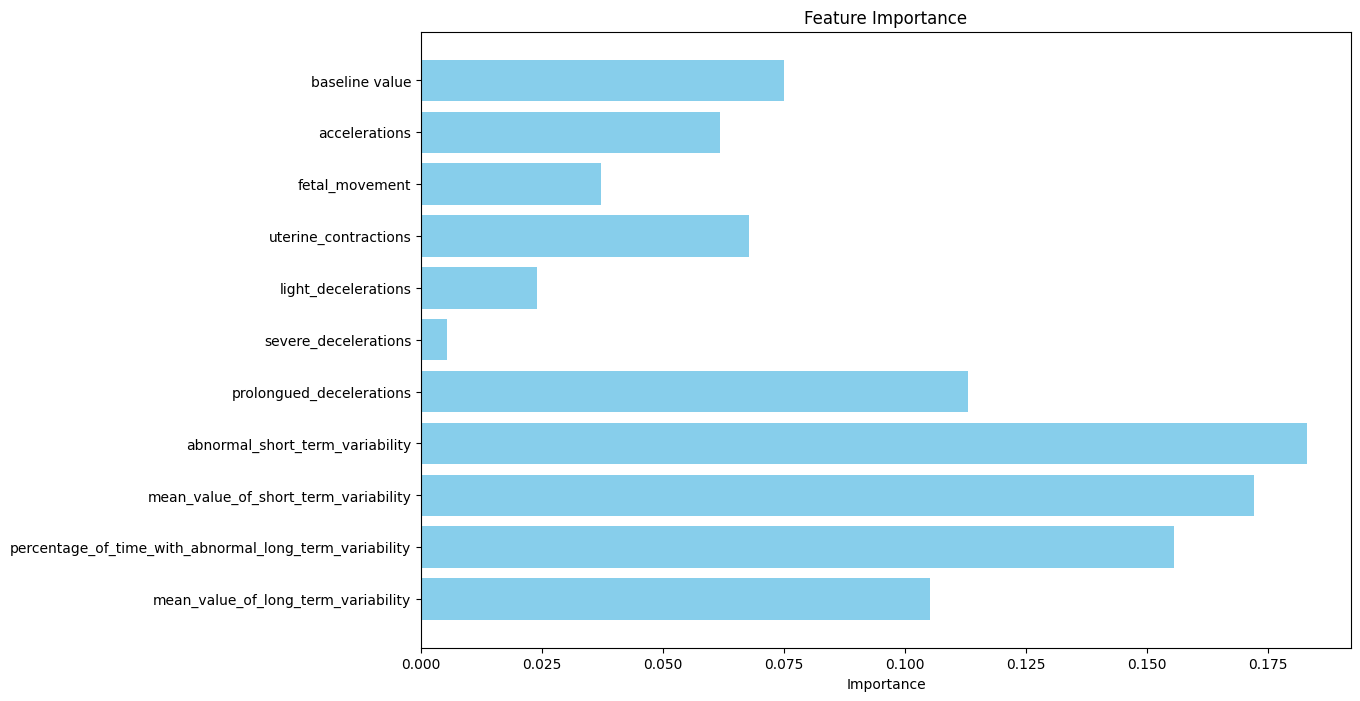

In [44]:
# Get feature importances from the random forest model
rf_feature_importances = rf_classifier.feature_importances_

# Get the feature names from the original dataset
feature_names = X.columns.tolist()

# Combine feature names and their importance scores into a DataFrame for easier analysis
rf_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_feature_importances})

# Show the top features contributing to the Random Forest model
print("Random Forest Feature Importances:")


In [ ]:
#Feature Importance Curve

plt.figure(figsize=(12, 8))
plt.barh(rf_importances_df['Feature'], rf_importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()